# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

import warnings
from scipy.stats import t
from scipy import stats
from scipy.stats import entropy
import random
warnings.filterwarnings("ignore")

2024-07-24 19:16:53.556210: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 19:16:53.558840: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 19:16:53.567930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 19:16:53.586707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 19:16:53.586740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 19:16:53.599464: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks"
}

# Load genotype

In [3]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
name_risk

'square_risk'

In [4]:
nr_common_PCs = 25
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
nr_rare_PCs = 25
rare_pc_columns = ['PC{}'.format(i) for i in range(1, nr_rare_PCs+1)]
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

In [5]:
complete

snps,CG3_AF_0.313875,CG6_AF_0.21065,CG13_AF_0.3178,CG14_AF_0.206575,CG17_AF_0.277,CG19_AF_0.3036,CG23_AF_0.2141,CG29_AF_0.303875,CG30_AF_0.304,CG31_AF_0.316825,...,VRG971_AF_0.0261,VRG973_AF_0.04725,VRG976_AF_0.036725,VRG979_AF_0.02685,VRG981_AF_0.02075,VRG989_AF_0.033775,VRG991_AF_0.02855,VRG993_AF_0.02275,VRG998_AF_0.020175,VRG999_AF_0.030175
0,-1.0,1.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19996,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19997,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19998,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Load populations

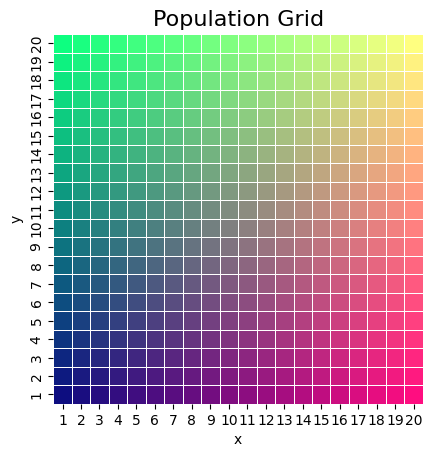

In [6]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()



# True MAF per populations

In [7]:
"""
complete['pop'] = populations['population_number']

p2s_dfs = []
q2s_dfs = []
twopqs_dfs = []
for pop in list(populations['population_number'].unique()):
    snps = []
    p2s = []
    twopqs = []
    q2s = []
    temp = complete[complete['pop'] == pop]
    temp.drop("pop", axis=1, inplace=True)
    for snp in list(temp.columns):
        try:
            num_maj = temp[[snp]].value_counts()[1]
        except Exception as e:
            num_maj = 0
        try:
            num_het = temp[[snp]].value_counts()[0]
        except Exception as e:
            num_het = 0
        try:
            num_min = temp[[snp]].value_counts()[-1]
        except Exception as e:
            num_min = 0
        total_humans = num_maj + num_het + num_min
        p2 = [num_maj/total_humans]*total_humans
        twopq = [num_het/total_humans]*total_humans
        q2 = [num_min/total_humans]*total_humans
        p2s.append(p2)
        twopqs.append(twopq)
        q2s.append(q2)
        snps.append(snp)
    p2s = pd.DataFrame(p2s).T
    p2s.index = temp.index
    p2s.columns = snps

    twopqs = pd.DataFrame(twopqs).T
    twopqs.index = temp.index
    twopqs.columns = snps

    q2s = pd.DataFrame(q2s).T
    q2s.index = temp.index
    q2s.columns = snps

    p2s_dfs.append(p2s)
    twopqs_dfs.append(twopqs)
    q2s_dfs.append(q2s)

complete.drop("pop", axis=1, inplace=True)

true_p2s = pd.concat(p2s_dfs)
true_twopqs = pd.concat(twopqs_dfs)
true_q2s = pd.concat(q2s_dfs)

true_p2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
true_twopqs.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
true_q2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")
"""

'\ncomplete[\'pop\'] = populations[\'population_number\']\n\np2s_dfs = []\nq2s_dfs = []\ntwopqs_dfs = []\nfor pop in list(populations[\'population_number\'].unique()):\n    snps = []\n    p2s = []\n    twopqs = []\n    q2s = []\n    temp = complete[complete[\'pop\'] == pop]\n    temp.drop("pop", axis=1, inplace=True)\n    for snp in list(temp.columns):\n        try:\n            num_maj = temp[[snp]].value_counts()[1]\n        except Exception as e:\n            num_maj = 0\n        try:\n            num_het = temp[[snp]].value_counts()[0]\n        except Exception as e:\n            num_het = 0\n        try:\n            num_min = temp[[snp]].value_counts()[-1]\n        except Exception as e:\n            num_min = 0\n        total_humans = num_maj + num_het + num_min\n        p2 = [num_maj/total_humans]*total_humans\n        twopq = [num_het/total_humans]*total_humans\n        q2 = [num_min/total_humans]*total_humans\n        p2s.append(p2)\n        twopqs.append(twopq)\n        q2s.

In [8]:
true_p2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
true_twopqs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
true_q2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")

# Create phenotype only SNP dependent

# Effect based on AF

In [9]:
def multi(arr, effectsize):
    return [1 * (num + 0.001) * effectsize for num in arr]

def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

In [10]:
effectsize = 1
numbers_af = [float(col.split('_AF_')[1]) for col in common.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in common.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_common = pd.DataFrame(data)
beta_common['maf'] = "common"

numbers_af = [float(col.split('_AF_')[1]) for col in rare.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in rare.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_rare = pd.DataFrame(data)
beta_rare['maf'] = "rare"

numbers_af = [float(col.split('_AF_')[1]) for col in very_rare.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in very_rare.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_very_rare = pd.DataFrame(data)
beta_very_rare['maf'] = "very rare"

betas = pd.concat([beta_common, beta_rare, beta_very_rare], ignore_index=True)

# Monogenic phenotype

In [11]:
all_snps = list(complete.columns)
phenos_mono = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    phenos_mono.append(complete[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = complete.columns

# Add noise
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / 0.001
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)

In [12]:
# Polygenic phenotype
"""
# Polygenic phenotype
proportion_poly = 0.05
poly_friends_quantity = int(np.round(len(all_snps)*proportion_poly))
phenos_poly = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    temp = complete[snp] * beta_value
    poly_snps = random.sample(all_snps, poly_friends_quantity)
    for poly_snp in poly_snps:
        beta_expected = betas.loc[betas['snp'] == poly_snp.split("_")[0], 'Beta'].values[0]
        temp += complete[snp]*(beta_expected/10)
    phenos_poly.append(temp)
# Converting phenos_mono list of series to DataFrame directly
phenos_poly = pd.concat(phenos_poly, axis=1)
phenos_poly.columns = complete.columns
"""

'\n# Polygenic phenotype\nproportion_poly = 0.05\npoly_friends_quantity = int(np.round(len(all_snps)*proportion_poly))\nphenos_poly = []\nfor snp in all_snps:\n    index_snp = snp.split(\'_\')[0]\n    beta_value = betas.loc[betas[\'snp\'] == index_snp, \'Beta\'].values[0]\n    temp = complete[snp] * beta_value\n    poly_snps = random.sample(all_snps, poly_friends_quantity)\n    for poly_snp in poly_snps:\n        beta_expected = betas.loc[betas[\'snp\'] == poly_snp.split("_")[0], \'Beta\'].values[0]\n        temp += complete[snp]*(beta_expected/10)\n    phenos_poly.append(temp)\n# Converting phenos_mono list of series to DataFrame directly\nphenos_poly = pd.concat(phenos_poly, axis=1)\nphenos_poly.columns = complete.columns\n'

# Starting comparaisons

In [13]:
df_no_corr = manhattan_linear(complete, phenos_mono)
df_no_corr = pd.merge(df_no_corr, betas, on='snp')

Snp specific phenotype!
No Covs!


In [14]:
pops = populations[['x','y']]
df_pops = manhattan_linear(complete, phenos_mono , pops)
df_pops = pd.merge(df_pops, betas, on='snp')

Snp specific phenotype!
Covs


In [15]:
df_pops

,snp,coefs,AFs,Ps,-logPs,Beta,maf
0,CG3,4.017289,0.313875,1.701769e-05,4.769099,3.175863,common
1,CG6,5.796168,0.21065,2.454613e-05,4.610017,4.724781,common
2,CG13,4.585887,0.3178,9.508570e-07,6.021885,3.136763,common
3,CG14,1.116509,0.206575,4.298406e-01,0.366693,4.817536,common
4,CG17,4.852830,0.277,7.881923e-08,7.103368,3.597122,common
...,...,...,...,...,...,...,...
995,VRG989,32.912628,0.033775,2.711751e-07,6.566750,28.756290,very rare
996,VRG991,37.922939,0.02855,7.619085e-07,6.118097,33.840948,very rare
997,VRG993,43.014618,0.02275,6.196608e-06,5.207846,42.105263,very rare
998,VRG998,38.489021,0.020175,2.380584e-04,3.623317,47.225502,very rare


In [16]:
# p2 - q2 and 2pq as covariates
covariate_dictionary = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = true_p2s[snp] - true_q2s[snp]
    temp[f"{snp}_cov_2pq"] = true_twopqs[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary[snp] = temp

In [17]:
df_p_q_2pq_covs = manhattan_linear(complete, phenos_mono, covariate_dictionary)

Snp specific phenotype!
Dictionary Match!


# Create qq plots

In [18]:
# Create QQ plot
df_bests = pd.DataFrame()
df_bests["-logP_no_corr"] = np.sort(df_no_corr['-logPs'])
df_bests["-logP_true_pop"] = np.sort(df_pops['-logPs'])
df_bests["-logP_pq_2pq_as_cov"] = np.sort(df_p_q_2pq_covs['-logPs'])


In [19]:
# Find the maximum value in the DataFrame excluding inf and NaN
max_value = df_bests.replace([np.inf, -np.inf], np.nan).max().max()

# Replace inf values with the maximum value found
df_bests.replace([np.inf, -np.inf], max_value, inplace=True)

# Replace NaN values with the maximum value found
df_bests.fillna(max_value, inplace=True)
n = len(df_bests)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles))
df_bests['expected_logP'] = expected_logP

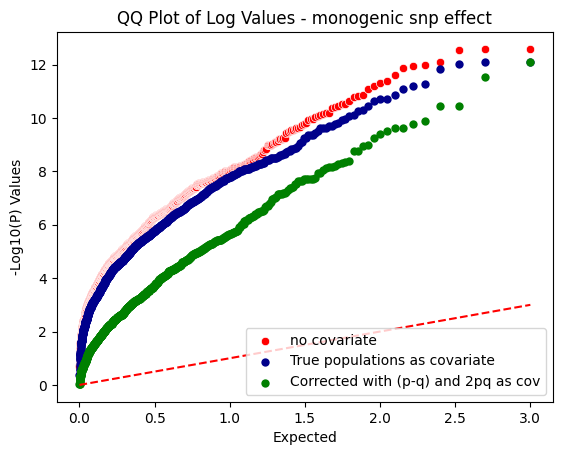

In [20]:
sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate')

sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations as covariate', linewidth=0)

#sns.scatterplot(x='expected_logP', y='-logP_corrected_geno_true_mafs', data=df_bests, color='purple', label='Corrected genotype with true MAFs', linewidth=0)

#sns.scatterplot(x='expected_logP', y='-logP_corrected_pheno_true_mafs', data=df_bests, color='pink', label='Corrected phenotype with true MAFs', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_pq_2pq_as_cov', data=df_bests, color='green', label='Corrected with (p-q) and 2pq as cov', linewidth=0)

#sns.scatterplot(x='expected_logP', y='-logP_pq_as_cov', data=df_bests, color='darkgreen', label='Corrected with (p-q)', linewidth=0)

# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - monogenic snp effect")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

# Effect plot

In [21]:
# Create QQ plot
df_effect = pd.DataFrame()
df_effect["beta_no_corr"] = df_no_corr['coefs']
df_effect["beta_true_pop"] = df_pops['coefs']
df_effect["beta_pq_2pq_as_cov"] = df_p_q_2pq_covs['coefs']
df_effect['true_beta'] = df_no_corr['Beta']

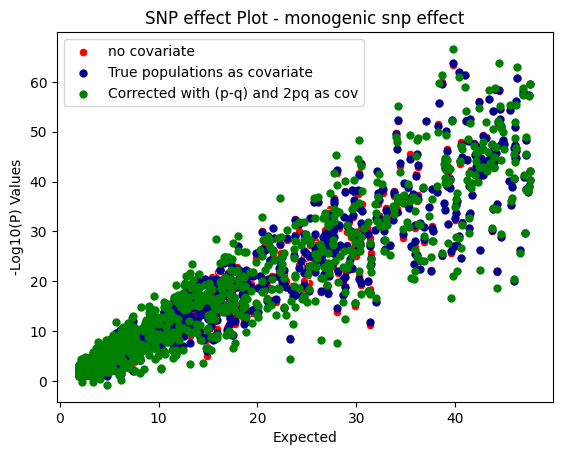

In [22]:
sns.scatterplot(x='true_beta', y='beta_no_corr', data=df_effect, color='red', label='no covariate')

sns.scatterplot(x='true_beta', y='beta_true_pop', data=df_effect, color='darkblue', label='True populations as covariate', linewidth=0)

#sns.scatterplot(x='true_beta', y='beta_corrected_geno_true_mafs', data=df_effect, color='purple', label='Corrected genotype with true MAFs', linewidth=0)

#sns.scatterplot(x='true_beta', y='beta_corrected_pheno_true_mafs', data=df_effect, color='pink', label='Corrected phenotype with true MAFs', linewidth=0)

sns.scatterplot(x='true_beta', y='beta_pq_2pq_as_cov', data=df_effect, color='green', label='Corrected with (p-q) and 2pq as cov', linewidth=0)

#sns.scatterplot(x='true_beta', y='beta_pq_as_cov', data=df_effect, color='darkgreen', label='Corrected with (p-q)', linewidth=0)


# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"SNP effect Plot - monogenic snp effect")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

In [23]:
complete

snps,CG3_AF_0.313875,CG6_AF_0.21065,CG13_AF_0.3178,CG14_AF_0.206575,CG17_AF_0.277,CG19_AF_0.3036,CG23_AF_0.2141,CG29_AF_0.303875,CG30_AF_0.304,CG31_AF_0.316825,...,VRG971_AF_0.0261,VRG973_AF_0.04725,VRG976_AF_0.036725,VRG979_AF_0.02685,VRG981_AF_0.02075,VRG989_AF_0.033775,VRG991_AF_0.02855,VRG993_AF_0.02275,VRG998_AF_0.020175,VRG999_AF_0.030175
0,-1.0,1.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19996,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19997,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19998,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Now with PCA and abyss

In [24]:
try:
    file_list = os.listdir(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/")
    to_add = max([int(f.split('_')[2].split('.pkl')[0]) for f in file_list if f != '.ipynb_checkpoints'])
    q2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/q2_iteration_{to_add}.pkl")
    twopq = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/2pq_iteration_{to_add}.pkl")
    p2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/p2_iteration_{to_add}.pkl")
except Exception as e:
    print(e)
    q2 = db_minor.copy()
    twopq = db_het.copy()
    p2 = db_major.copy()

In [26]:
covariate_dictionary = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = p2[snp] - q2[snp]
    temp[f"{snp}_cov_2pq"] = twopq[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary[snp] = temp

In [27]:
df_abyss_p_q_2pq_covs = manhattan_linear(complete, phenos_mono, covariate_dictionary)

Snp specific phenotype!
Dictionary Match!


In [28]:
# PCA
nr_common_PCs = 20
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
df_PCs = manhattan_linear(complete, phenos_mono , PC_common[pc_columns])

Snp specific phenotype!
Covs


In [29]:
df_bests["-logP_abyss"] = np.sort(df_abyss_p_q_2pq_covs['-logPs'])
df_bests["-logP_PCs"] = np.sort(df_PCs['-logPs'])

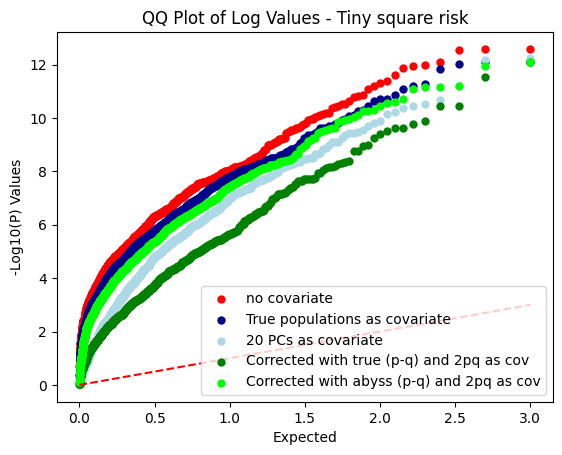

In [30]:
sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations as covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_PCs', data=df_bests, color='lightblue', label=f"{nr_common_PCs} PCs as covariate", linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_pq_2pq_as_cov', data=df_bests, color='green', label='Corrected with true (p-q) and 2pq as cov', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_abyss', data=df_bests, color='lime', label='Corrected with abyss (p-q) and 2pq as cov', linewidth=0)


# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

In [34]:
df_effect

,beta_no_corr,beta_true_pop,beta_pq_2pq_as_cov,true_beta,beta_abyss,beta_PC
0,3.243884,4.017289,4.154389,3.175863,4.260746,2.803096
1,5.773362,5.796168,8.256934,4.724781,6.595186,5.584649
2,3.967428,4.585887,4.747221,3.136763,4.636888,4.887193
3,2.424527,1.116509,-0.763864,4.817536,0.465838,-0.551616
4,5.730936,4.852830,5.427706,3.597122,4.668401,4.877102
...,...,...,...,...,...,...
995,32.955750,32.912628,26.127599,28.756290,32.514528,32.091358
996,38.097183,37.922939,33.510498,33.840948,37.367454,37.971923
997,43.101481,43.014618,44.204490,42.105263,43.075091,42.738546
998,38.522507,38.489021,38.361367,47.225502,38.487785,38.448518


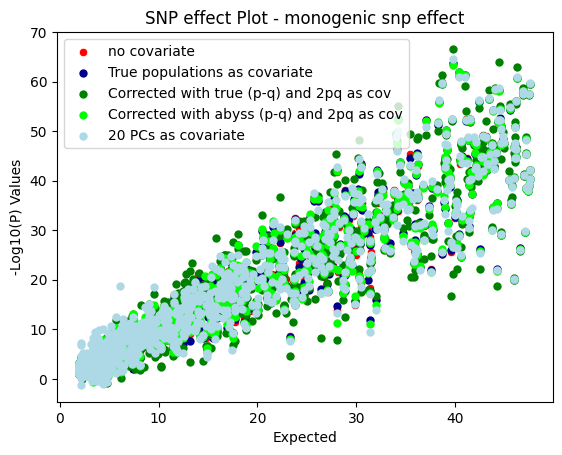

In [36]:
sns.scatterplot(x='true_beta', y='beta_no_corr', data=df_effect, color='red', label='no covariate')

sns.scatterplot(x='true_beta', y='beta_true_pop', data=df_effect, color='darkblue', label='True populations as covariate', linewidth=0)

sns.scatterplot(x='true_beta', y='beta_pq_2pq_as_cov', data=df_effect, color='green', label='Corrected with true (p-q) and 2pq as cov', linewidth=0)

sns.scatterplot(x='true_beta', y='beta_abyss', data=df_effect, color='lime', label='Corrected with abyss (p-q) and 2pq as cov', linewidth=0)

sns.scatterplot(x='true_beta', y='beta_PC', data=df_effect, color='lightblue', label=f"{nr_common_PCs} PCs as covariate", linewidth=0)


# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"SNP effect Plot - monogenic snp effect")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()